# Capstone Project -- The Battle of Neighborhoods 

## Week 4 / 5 -- *Applied Data Science Capstone by IBM/Coursera*

## 0) Table of Contents

This is the final capstone project of the course Applied Data Science Capstone of the course circle
https://www.coursera.org/professional-certificates/ibm-data-science 

This notebook contains multiple parts:
   
Week 1:

 1) Problem description and background discussion 
    
 2) Data description and how the data will help to solve the problem 

Week 2:

 1 ) Methodology and Exploratory Data Analysis

 2 ) Discussion


## Week 1: 
### 1) Introduction and Discussion of the Business Objective and Problem

In this project we want to find a good location for a restaurant. Specifically, we are interested in opening an **American burger restaurant** in **Rome** the capital of Italy. Rome is the home of 3 mio people. Although there is a trend towards eating healthier food, burger restaurants still enjoy great popularity.

We are also particularly interested in areas with other burger restaurants in neighborhood. We would also prefer locations **as close to city center as possible**. Chosing the right location for business is one of the difficult and discussable tasks, since there are a lot of criteria to be considered in order to achieve the high revenue. 

We want to look at the following influencing factor:

 * the number of burger restaurants in the same zone
 * solvency of the population around the location 

In this project, we will implement the basic analysis and try to find the most optimal neighborhood to open a new burger restaurant according to those criteria. It's clear, that there are a lot of other additional factors, such as distance from parking places or distance from the main streets and sights are important.
However this analysis can be done after choosing the Borough, and thus will not be done within the scope of this project.



## 2) Data acquisition

### 2.1 Data source

* Geographical information
    * Wikipedia Data of Rome
    * Shapefile of Municipi di Roma: http://www.datiopen.it/it/opendata/Municipi_di_Roma_Capitale
    * Shapefile of Zone urbane: https://www.mapparoma.info/zone-urbanistiche/
* Statistical data of the municipi of Rome
    * Average Income figures of 2015 from https://www.comune.roma.it/web/it/analisi-statistiche.page
* Restaurant type information
    * Foursquare API: selection of restaurants accourding to the category type and location

### 2.2 Feature selection


* Using Fourshquare to get all burger restaurant in Rome with attributes of ID, name, category (burger restaurant), gps coordinate
* Using Foursquare API

*Python packages*

In [1]:
import requests
import lxml.html as lh
import pandas as pd
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
import geoplot
import os
from pyproj import Proj
from geopandas.tools import sjoin

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

## Week 2: Exploring Rome

### Define some helper functions

In [2]:
def decode_roman_numeral(roman):
    """Calculate the numeric value of a roman letter"""
    trans = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    values = [trans[r] for r in roman]
    return sum(
        val if val >= next_val else -val
        for val, next_val in zip(values[:-1], values[1:])
    ) + values[-1]

In [3]:
def get_lat_lon(df,used_column,city):

    geolocator = Nominatim(user_agent="explorer")    
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3,error_wait_seconds=5)
    latitude=[]
    longitude=[]
    for zone_name in df[used_column]:
        zone_name_ext = zone_name + ',' +  city
        #lat_lng_coords = None
        #while(lat_lng_coords is None):
        location = geocode('{}'.format(zone_name_ext))  
        if location == None:
            print('')
            latitude.append(0)
            longitude.append(0)
        else:
            print(location)
            print(location[1][0])    
            print(location[1][1])
            latitude.append(location[1][0])    
            longitude.append(location[1][1])

    df.insert(len(df.columns),'Latitude',latitude)
    df.insert(len(df.columns),'Longitude',longitude)
    
    return df

### Get geometry information of the municipi in Rome

In [4]:
municipi_shape_full = gpd.read_file('src_external/Municipi_Roma_15_wgs84_1.shp')
municipi_shape_full['centroid'] = municipi_shape_full.centroid
df_municipi_geometry = municipi_shape_full[['municipio','zone_urb','geometry','centroid']].copy(deep=True)

In [5]:
municipi_shape_full.head()

,municipio,zone_urb,rione,quartiere,sub_urbio,zone_agro,borgate,ex_mun,etichetta,geometry,centroid
0,1,"Centro Storico,Trastevere,Aventino,Testaccio,E...","Monti,Trevi,Colonna,Campo Marzio,Ponte,Parione...","Ostiense (parte),Ardeatino (parte),Trionfale (...",-,-,-,1-17,I (Ex I - XVII),"POLYGON ((12.44396 41.93391, 12.44473 41.93212...",POINT (12.47795 41.89863)
1,2,"Villaggio Olimpico,Parioli,Flaminio,Salario,Tr...",Castro Pretorio (parte),"Flaminio,Parioli,Pinciano,Salario,Trieste (par...",-,-,-,2-3,II (Ex II - III),"POLYGON ((12.50099 41.94215, 12.50117 41.94199...",POINT (12.50118 41.92070)
2,3,"Montesacro,Val Melaina,Monte Sacro Alto,Fidene...",-,"Monte Sacro,Trieste (parte),Monte Sacro Alto",-,"Val Melaina,Castel Giubileo,Marcigliana,Casal ...","Prato Rotondo, Fidene",4,III (Ex IV),"POLYGON ((12.56322 42.07465, 12.56270 42.07313...",POINT (12.55432 41.99644)
3,4,"Casal Bertone,Casal Bruciato,Tiburtino Nord,Ti...",-,"Tiburtino (parte),Pietralata,Collatino (parte)...",-,"Settecamini,Tor Cervara (parte),Tor Sapienza (...",-,5,IV (Ex V),"POLYGON ((12.63543 41.95729, 12.63697 41.95728...",POINT (12.59134 41.93216)
4,5,"Torpignattara,Casilino,Quadraro,Gordiani,Cento...",-,"Tiburtino (parte),Prenestino-Labicano (parte),...",-,"Tor Cervara (parte),Tor Sapienza (parte),Torre...","Pigneto, Gordiani",6-7,V (Ex VI - VII),"POLYGON ((12.61539 41.89947, 12.61530 41.89640...",POINT (12.57557 41.88910)


### Get average Income per municipi

In [6]:
df_income = pd.read_excel('src_external/Redditi_2015.xls',sheet_name="Tab_3", header=[1, 4])
df_income_cleaned = df_income.iloc[0:15, [0,1]].copy(deep=True)
df_income_cleaned.reset_index(level=[0])
df_income_cleaned.columns = ['MunicipioNr','AverageIncome']
df_income_cleaned['municipio'] = [str(decode_roman_numeral(n)) for n in df_income_cleaned['MunicipioNr'].str.extract(r'Municipio\s?([XVI]+)', expand=False).tolist()]
df_income_cleaned.drop(['MunicipioNr'], axis=1,inplace=True)

### Get statistical information of the municipi in Rome

In [7]:
municipiourl = r'https://en.wikipedia.org/wiki/Administrative_subdivision_of_Rome'
df_municipi_wiki = pd.read_html(municipiourl)[1]
df_municipi_wiki[['MunicipioNr','MunicipioName']] = df_municipi_wiki.Municipio.str.split("–",expand=True)
df_municipi_wiki.drop(['Map'],inplace=True,axis=1)
df_municipi_wiki['municipio'] = [str(decode_roman_numeral(n)) for n in df_municipi_wiki['MunicipioNr'].str.extract(r'Municipio\s?([XVI]+)', expand=False).tolist()]

In [8]:
df_municipi_statdata = pd.merge(df_municipi_wiki,df_income_cleaned, left_on='municipio', right_on='municipio')
df_municipi_statdata.columns = ['Municipio','Population','Area','Density','MunicipioNr','MunicipioName','municipio','AverageIncome']

In [9]:
df_municipi_statdata.head()

,Municipio,Population,Area,Density,MunicipioNr,MunicipioName,municipio,AverageIncome
0,Municipio I – Historical Center,186802,19.91,9382,Municipio I,Historical Center,1,37595.764235
1,Municipio II – Parioli/Nomentano,167736,19.60,8567,Municipio II,Parioli/Nomentano,2,40530.398209
2,Municipio III – Monte Sacro,204514,97.82,2091,Municipio III,Monte Sacro,3,25379.523995
3,Municipio IV – Tiburtina,177084,49.15,3603,Municipio IV,Tiburtina,4,21195.881921
4,Municipio V – Prenestino/Centocelle,246471,27.00,9137,Municipio V,Prenestino/Centocelle,5,18773.219345


In [10]:
df_municipi_geometry['LatitudeCent'] = df_municipi_geometry.centroid.apply(lambda p: round(p.y,7)).astype(float)
df_municipi_geometry['LongitudeCent'] = df_municipi_geometry.centroid.apply(lambda p: round(p.x,7)).astype(float)

In [38]:
df_municipi_geometry.head()

,municipio,zone_urb,geometry,centroid,LatitudeCent,LongitudeCent
0,1,"Centro Storico,Trastevere,Aventino,Testaccio,E...","POLYGON ((12.44396 41.93391, 12.44473 41.93212...",POINT (12.47795 41.89863),41.898628,12.477950
1,2,"Villaggio Olimpico,Parioli,Flaminio,Salario,Tr...","POLYGON ((12.50099 41.94215, 12.50117 41.94199...",POINT (12.50118 41.92070),41.920704,12.501180
2,3,"Montesacro,Val Melaina,Monte Sacro Alto,Fidene...","POLYGON ((12.56322 42.07465, 12.56270 42.07313...",POINT (12.55432 41.99644),41.996439,12.554324
3,4,"Casal Bertone,Casal Bruciato,Tiburtino Nord,Ti...","POLYGON ((12.63543 41.95729, 12.63697 41.95728...",POINT (12.59134 41.93216),41.932162,12.591343
4,5,"Torpignattara,Casilino,Quadraro,Gordiani,Cento...","POLYGON ((12.61539 41.89947, 12.61530 41.89640...",POINT (12.57557 41.88910),41.889105,12.575565


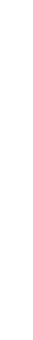

In [39]:
geoplot.choropleth(zone_shape, hue='SUPERFICIE')

In [12]:
address_rome = 'Rome, Italia'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address_rome)
rome_latitude = location.latitude
rome_longitude = location.longitude
print('The geographical coordinates of Rome are {}, {}.'.format(rome_latitude, rome_longitude))

The geographical coordinates of Rome are 41.8933203, 12.4829321.


In [13]:
df_municipi_statdata

,Municipio,Population,Area,Density,MunicipioNr,MunicipioName,municipio,AverageIncome
0,Municipio I – Historical Center,186802,19.91,9382,Municipio I,Historical Center,1,37595.764235
1,Municipio II – Parioli/Nomentano,167736,19.60,8567,Municipio II,Parioli/Nomentano,2,40530.398209
2,Municipio III – Monte Sacro,204514,97.82,2091,Municipio III,Monte Sacro,3,25379.523995
3,Municipio IV – Tiburtina,177084,49.15,3603,Municipio IV,Tiburtina,4,21195.881921
4,Municipio V – Prenestino/Centocelle,246471,27.00,9137,Municipio V,Prenestino/Centocelle,5,18773.219345
5,Municipio VI – Roma Delle Torri,256261,113.40,2261,Municipio VI,Roma Delle Torri,6,17053.825757
6,Municipio VII – Appio-Latino/Tuscolano/Cinecittà,307607,46.80,6580,Municipio VII,Appio-Latino/Tuscolano/Cinecittà,7,24048.151537
7,Municipio VIII – Appia Antica,131082,47.29,2772,Municipio VIII,Appia Antica,8,28007.848347
8,Municipio IX – EUR,180511,183.17,985,Municipio IX,EUR,9,29587.851508
9,Municipio X – Ostia/Acilia,230544,150.64,1530,Municipio X,Ostia/Acilia,10,22726.660748


In [14]:
df_municipi_geometry

,municipio,zone_urb,geometry,centroid,LatitudeCent,LongitudeCent
0,1,"Centro Storico,Trastevere,Aventino,Testaccio,E...","POLYGON ((12.44396 41.93391, 12.44473 41.93212...",POINT (12.47795 41.89863),41.898628,12.477950
1,2,"Villaggio Olimpico,Parioli,Flaminio,Salario,Tr...","POLYGON ((12.50099 41.94215, 12.50117 41.94199...",POINT (12.50118 41.92070),41.920704,12.501180
2,3,"Montesacro,Val Melaina,Monte Sacro Alto,Fidene...","POLYGON ((12.56322 42.07465, 12.56270 42.07313...",POINT (12.55432 41.99644),41.996439,12.554324
3,4,"Casal Bertone,Casal Bruciato,Tiburtino Nord,Ti...","POLYGON ((12.63543 41.95729, 12.63697 41.95728...",POINT (12.59134 41.93216),41.932162,12.591343
4,5,"Torpignattara,Casilino,Quadraro,Gordiani,Cento...","POLYGON ((12.61539 41.89947, 12.61530 41.89640...",POINT (12.57557 41.88910),41.889105,12.575565
5,6,"Torre Spaccata,Torre Maura,Giardinetti-Tor Ver...","POLYGON ((12.70672 41.93375, 12.70692 41.93291...",POINT (12.68712 41.88755),41.887550,12.687117
6,7,"Tuscolano Nord,Tuscolano Sud,Tor Fiscale,Appio...","POLYGON ((12.51669 41.89194, 12.52267 41.88880...",POINT (12.58190 41.83904),41.839042,12.581899
7,8,"Ostiense,Valco San Paolo,Garbatella,Navigatori...","POLYGON ((12.48109 41.87642, 12.48138 41.87575...",POINT (12.52917 41.82867),41.828667,12.529168
8,9,"Eur,Villaggio Giuliano,Torrino,Laurentino,Cecc...","POLYGON ((12.47555 41.84735, 12.47616 41.84584...",POINT (12.49781 41.75765),41.757649,12.497813
9,10,"Malafede,Acilia Nord,Acilia Sud,Casal Palocco,...","POLYGON ((12.35256 41.80295, 12.35352 41.80286...",POINT (12.36310 41.73939),41.739390,12.363100


In [15]:
rome_income = folium.Map(location=[rome_latitude, rome_longitude], zoom_start=10, tiles='CartoDB positron')

# TODO: FIXME
folium.Choropleth(
    geo_data=df_municipi_geometry.drop('centroid',axis=1),
    data=df_municipi_statdata,
    columns=['municipio','AverageIncome'],
    key_on='feature.properties.municipio',    
    fill_color='Greens',
    legend_name='Per Capita Income by "Municipio"').add_to(rome_income)


locations = df_municipi_geometry[['LatitudeCent','LongitudeCent']].values
names = df_municipi_statdata['MunicipioName'].tolist()
nums = df_municipi_statdata['municipio'].tolist()

for loc, num, name in zip(locations, nums, names):
    folium.Marker(loc, popup=folium.Popup('<center><b>Municipio ' + str(num) + '</b></br>' + name + '</center>')
        ).add_to(rome_income)

rome_income

In [16]:
df_municipi_geometry.head()

,municipio,zone_urb,geometry,centroid,LatitudeCent,LongitudeCent
0,1,"Centro Storico,Trastevere,Aventino,Testaccio,E...","POLYGON ((12.44396 41.93391, 12.44473 41.93212...",POINT (12.47795 41.89863),41.898628,12.477950
1,2,"Villaggio Olimpico,Parioli,Flaminio,Salario,Tr...","POLYGON ((12.50099 41.94215, 12.50117 41.94199...",POINT (12.50118 41.92070),41.920704,12.501180
2,3,"Montesacro,Val Melaina,Monte Sacro Alto,Fidene...","POLYGON ((12.56322 42.07465, 12.56270 42.07313...",POINT (12.55432 41.99644),41.996439,12.554324
3,4,"Casal Bertone,Casal Bruciato,Tiburtino Nord,Ti...","POLYGON ((12.63543 41.95729, 12.63697 41.95728...",POINT (12.59134 41.93216),41.932162,12.591343
4,5,"Torpignattara,Casilino,Quadraro,Gordiani,Cento...","POLYGON ((12.61539 41.89947, 12.61530 41.89640...",POINT (12.57557 41.88910),41.889105,12.575565


In [17]:
#rome_map = folium.Map(location=[rome_latitude, rome_longitude], zoom_start=10, tiles='CartoDB positron')

#folium.Choropleth(
#    geo_data=df_municipi_geometry.drop('centroid',axis=1),    
#    fill_color='yellow', 
#    fill_opacity=0.6, 
#    line_color='black',
#    line_weight=2,
#    ).add_to(rome_map)

#locations = df_municipi_geometry[['LatitudeCent','LongitudeCent']].values
#names = df_municipi_statdata['MunicipioName'].tolist()
#nums = df_municipi_statdata['municipio'].tolist()

#for loc, num, name in zip(locations, nums, names):
#    folium.Marker(loc, popup=folium.Popup('<center><b>Municipio ' + str(num) + '</b></br>' + name + '</center>')
#        ).add_to(rome_map)
    
#rome_map

In [18]:
df_zones = pd.read_html('https://fr.wikipedia.org/wiki/Zones_de_Rome')[0]
dfz1=df_zones[[0,1]] #.iloc [1:, [0, 1]]#.reset_index()
dfz2=df_zones[[2,3]] #.iloc [1:, [2, 3]]#%.reset_index()
dfz3=df_zones[[4,5]] # .iloc [1:, [4, 5]]#%.reset_index()
dfz1.columns = ['N_ID', 'Name of the zone']
dfz2.columns = ['N_ID', 'Name of the zone']
dfz3.columns = ['N_ID', 'Name of the zone']
dfs1 = dfz1.iloc[1:]
dfs2 = dfz2.iloc[1:]
dfs3 = dfz3.iloc[1:]
dfs_combined = dfs1.append(dfs2).append(dfs3).reset_index()
dfs_combined['N_ID'] = dfs_combined['N_ID'].str.replace('Z\.','')
dfs_combined['Name of the zone'] = dfs_combined['Name of the zone'].str.replace('\[1\]','').str.replace('\[2\]','')
dfs_combined.drop(columns=['index'],inplace=True)

### Fetch restaurant data

*fetch location of burger restaurants from Foursquare*

In [19]:
CLIENT_ID = '' # my Foursquare ID
CLIENT_SECRET = '' # my Foursquare Secret
VERSION = '20180604'
print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: PAHM5I1HMX0RDIUQIUHF5MGIWPOCH5LXOPAJYQ2GIWKBDEV4
CLIENT_SECRET:4JQEDCYKXEFMUJJB1NPWH1A4ZR2FLPA1L5F2U2KBZQYXXYDD


In [20]:
category = '4bf58dd8d48988d16c941735' # Burger
radius = 100_000 # define radius
LIMIT = 500 # limit of number of venues returned by Foursquare API

In [21]:
# categories for further investigations corncering US related venues
baseball = '4bf58dd8d48988d18c941735'
basketball = '4bf58dd8d48988d18b941735'
football = '4bf58dd8d48988d189941735'
rugby = '56aa371be4b08b9a8d573556'

donat = '4bf58dd8d48988d148941735'
diner = '4bf58dd8d48988d147941735'

In [22]:
# gps coordinates
rome_latitude = 41.8933203
rome_longitude = 12.4829321

In [23]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
 CLIENT_ID, 
   CLIENT_SECRET, 
    VERSION, 
   rome_latitude, 
   rome_longitude, 
    category,
      radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=PAHM5I1HMX0RDIUQIUHF5MGIWPOCH5LXOPAJYQ2GIWKBDEV4&client_secret=4JQEDCYKXEFMUJJB1NPWH1A4ZR2FLPA1L5F2U2KBZQYXXYDD&v=20180604&ll=41.8933203,12.4829321&categoryId=4bf58dd8d48988d16c941735&radius=100000&limit=500'

In [24]:
results = requests.get(url).json()
results.values();

In [25]:
venues = results['response']['groups'][0]['items']
venues_neighborhood = [results['response']['groups'][0]['items'][n]['venue']['location']['formattedAddress'] for n in range(len(venues))]  
venues_distance = [results['response']['groups'][0]['items'][n]['venue']['location']['distance'] for n in range(len(venues))]  
nearby_venues = pd.json_normalize(venues) # flatten JSON

In [26]:
nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet,venue.venuePage.id,venue.location.neighborhood
0,e-0-584407c4c5f8a71c825742e4-0,0,"[{'summary': 'This spot is popular', 'type': '...",584407c4c5f8a71c825742e4,Tommi's Burger Joint,Viale Guilio Cesare 193 - 195,41.908955,12.456788,"[{'label': 'display', 'lat': 41.90895487256578...",2778,00192,IT,Roma,Lazio,Italia,"[Viale Guilio Cesare 193 - 195, 00192 Roma Laz...","[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",0,[],NaN,NaN,NaN
1,e-0-4fad7a5ae4b01d34f6c204a1-1,0,"[{'summary': 'This spot is popular', 'type': '...",4fad7a5ae4b01d34f6c204a1,Kilo Restaurant,"Via Tirso, 30",41.918245,12.498625,"[{'label': 'display', 'lat': 41.91824510193424...",3064,00198,IT,Roma,Lazio,Italia,"[Via Tirso, 30 (Via Metauro), 00198 Roma Lazio...","[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",0,[],Via Metauro,90057695,NaN
2,e-0-4ba626a5f964a5205c3739e3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4ba626a5f964a5205c3739e3,Hard Rock Cafe Rome,Via Vittorio Veneto 62A/B,41.906361,12.489744,"[{'label': 'display', 'lat': 41.906361, 'lng':...",1557,00187,IT,Roma,Lazio,Italia,"[Via Vittorio Veneto 62A/B, 00187 Roma Lazio, ...","[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",0,[],NaN,NaN,NaN
3,e-0-56116270498efc11cb984b91-3,0,"[{'summary': 'This spot is popular', 'type': '...",56116270498efc11cb984b91,Ted Burger&Lobster,Via Terenzio,41.906188,12.463252,"[{'label': 'display', 'lat': 41.90618836637681...",2170,NaN,IT,Roma,Lazio,Italia,"[Via Terenzio, Roma Lazio, Italia]","[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",0,[],NaN,NaN,Prati
4,e-0-4fa9883fe4b027255a2c6c22-4,0,"[{'summary': 'This spot is popular', 'type': '...",4fa9883fe4b027255a2c6c22,Knick Knack Yoda (Dal Papa),"Piazza Risorgimento, 11",41.906534,12.456899,"[{'label': 'display', 'lat': 41.90653392768178...",2610,00193,IT,Roma,Lazio,Italia,"[Piazza Risorgimento, 11, 00193 Roma Lazio, It...","[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",0,[],NaN,NaN,NaN


In [27]:
print("Number of Restaurants: ", nearby_venues.shape[0])

Number of Restaurants:  100


In [28]:
nearby_venues['venue.name'].value_counts()

Old Wild West                    13
Burger King                       6
Ham Holy Burger                   4
T-Bone Station                    4
McDonald's                        4
T-Burger Station                  2
Roadhouse                         2
Molino                            1
BurBaCa                           1
Caffè Propaganda                  1
The Bramble                       1
Grazia & Graziella                1
The Barrel Bar & Grill            1
LasaGnaM                          1
Orfeo - Il Re Della Notte         1
Premiata Panineria al Pigneto     1
Fonzie - The Burger's House       1
Buffalo Bill                      1
Mama's Burger & Sandwich          1
Re Della Notte                    1
Mr Mad                            1
Porto Fluviale                    1
Seconda Fila Beer & Burger        1
Perfetto                          1
Tiberino                          1
Dolce                             1
Burger King Mirti                 1
Knick Knack Yoda (Dal Papa) 

In [29]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
selected_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, selected_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
[venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]

nearby_venues['neighborhood'] =  [venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]
nearby_venues['distance [m]'] = venues_distance

df_nearbyVenues = nearby_venues
df_nearbyVenues.head()

,id,name,categories,lat,lng,neighborhood,distance [m]
0,584407c4c5f8a71c825742e4,Tommi's Burger Joint,Burger Joint,41.908955,12.456788,Viale Guilio Cesare 193 - 195,2778
1,4fad7a5ae4b01d34f6c204a1,Kilo Restaurant,Burger Joint,41.918245,12.498625,"Via Tirso, 30 (Via Metauro)",3064
2,4ba626a5f964a5205c3739e3,Hard Rock Cafe Rome,American Restaurant,41.906361,12.489744,Via Vittorio Veneto 62A/B,1557
3,56116270498efc11cb984b91,Ted Burger&Lobster,Burger Joint,41.906188,12.463252,Via Terenzio,2170
4,4fa9883fe4b027255a2c6c22,Knick Knack Yoda (Dal Papa),Sandwich Place,41.906534,12.456899,"Piazza Risorgimento, 11",2610


df_nearbyVenues.categories.value_counts().head()

In [31]:
outname = 'burger_category.csv'

outdir = '.'
if not os.path.exists(outdir):
   os.mkdir(outdir)

fullname = os.path.join(outdir, outname)    
print(fullname)
df_nearbyVenues.to_csv(fullname)

./burger_category.csv


*use shape file of different zones in Rome to display amount of burger restaurants per zone*

In [32]:
zone_shape = gpd.read_file('src_external/ZU_COD.shp').drop(['Name', 'TIPZU'], axis=1)

In [33]:
zone_shape.head()

,ZU,CODZU,MUNICIPIO,GRA,SUPERFICIE,geometry
0,Tuscolano Nord,9A,7.0,1.0,107.0,"POLYGON Z ((294658.952 4639994.348 0.000, 2946..."
1,Tuscolano Sud,9B,7.0,1.0,316.0,"POLYGON Z ((294988.147 4637592.340 0.000, 2949..."
2,Tor Fiscale,9C,7.0,1.0,91.0,"POLYGON Z ((295420.892 4637038.028 0.000, 2954..."
3,Appio,9D,7.0,1.0,134.0,"POLYGON Z ((293294.576 4638903.640 0.000, 2932..."
4,Latino,9E,7.0,1.0,159.0,"POLYGON Z ((292789.674 4637982.143 0.000, 2927..."


In [34]:
zone_shape.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 12°E to 18°E - by country
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

***visualize number of burger restuarants with zone maps***

In [35]:
#geoplot.choropleth(zone_shape, hue='name',legend=True)

In [36]:
df_nearbyVenues.iloc[0,]

id                   584407c4c5f8a71c825742e4
name                     Tommi's Burger Joint
categories                       Burger Joint
lat                                    41.909
lng                                   12.4568
neighborhood    Viale Guilio Cesare 193 - 195
distance [m]                             2778
Name: 0, dtype: object

In [37]:
m = folium.Map(location=[rome_latitude, rome_longitude])

folium.Choropleth(geo_data=zone_shape, data=zone_shape, fill_color='YlGn', columns=['CODZU','name']).add_to(m)

for kpoint in range(len(df_nearbyVenues)):
    df_select = df_nearbyVenues.iloc[kpoint,]
    folium.Marker(        
        [df_select.lat,df_select.lng],
        radius=6,
        popup=df_select['name']).add_to(m)

m

KeyError: 'name'

In [ ]:
zone_shape['Latitude'] = zone_shape.geometry.centroid.apply(lambda p: round(p.y,10)).astype(float)
zone_shape['Longitude'] = zone_shape.geometry.centroid.apply(lambda p: round(p.x,10)).astype(float)

In [ ]:
type(df_nearbyVenues) 

In [ ]:
gdf_restaurant = gpd.GeoDataFrame(
    df_nearbyVenues, crs=4326, geometry=gpd.points_from_xy(x=df_nearbyVenues.lng, y=df_nearbyVenues.lat))

In [ ]:
gdf_restaurant.head()

In [ ]:
gdf_restaurant.crs

In [ ]:
gdf_restaurant.head(2)

In [ ]:
zone_shape = zone_shape.to_crs("EPSG:4326")

In [ ]:
pointInPolys = sjoin(gdf_restaurant, zone_shape, how='left')

In [ ]:
pointInPolys.info()

In [ ]:
ZUcounts = pointInPolys.groupby("CODZU").count()['name']

In [ ]:
zone_shape.head()

In [ ]:
ZUcounts.head()

In [ ]:
zone_shape = zone_shape.merge(ZUcounts, left_on='CODZU', right_on='CODZU')

In [ ]:
zone_shape.head()

In [ ]:
print(type(zone_shape))

In [ ]:
burger_select = zone_shape[['ZU','CODZU','name']].copy(deep=True)
burger_select.columns=['Zone','CODZU','NumberOfVenues']

In [ ]:
burger_select

In [ ]:
burger_select[burger_select.name > 1 ].plot.bar(x='ZU', y='name', rot=0)

In [ ]:
PALETTE = 'OrRd'
geoplot.choropleth(zone_shape, hue="name", legend=True, cmap = PALETTE, figsize = (20,10))

### Discussion

The optimal zones for a burger restaurant are Centro Storico (1A), Prati (17B), Esquilino (1F)